# Montecarlo Dropout
in this notebook we want implement mc dropout



In [1]:
%load_ext autoreload
%autoreload 2
%cd /home/florian/GitRepos/activeCell-ACDC
!ls

import json
import random as rd
import matplotlib.image as mpimg
import cv2
import wandb
import torch
import os

from detectron2.utils.visualizer import Visualizer
from detectron2.utils.logger import setup_logger
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.modeling import build_model
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.engine import DefaultPredictor

from src.globals import *
from src.visualization.show_image import show_image
from src.register_datasets import register_datasets, get_dataset_name
from src.config_builder import get_config




/home/florian/GitRepos/activeCell-ACDC
data		   log	   pipeline_configs  requirements.txt  src
jupyter_notebooks  output  README.md	     shell_scripts     wandb


## Register Datasets

In [2]:
register_datasets()

registering acdc_large dataset
registering acdc_small dataset
registering cellpose dataset


## Train MC Dropout Model

In [4]:

#!python ./src/pipeline_runner.py -f ./pipeline_configs/dropout_acdc_small_full_ds_local.yaml

registering acdc_large dataset
registering acdc_small dataset
registering cellpose dataset
running on server: False
/home/florian/GitRepos/activeCell-ACDC/src/train.py:23: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  wandb.config.update(yaml.load(cfg.dump()))
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if th

WARNING [12/09 09:05:11 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



/home/florian/.local/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


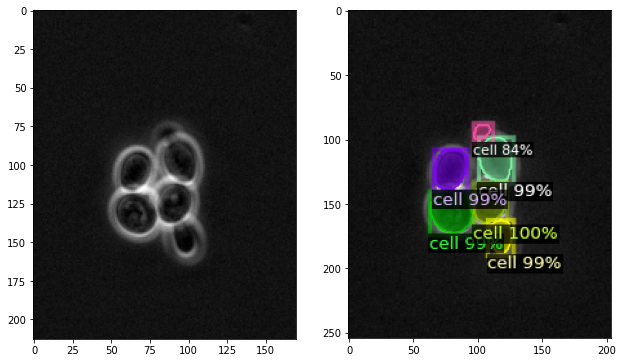

In [3]:
import os
from detectron2.engine import DefaultPredictor
cfg = get_config("dropout_acdc_small_full_ds_local")
logger = setup_logger(output="./log/main.log")
logger.setLevel(0)
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth") 
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7 
predictor = DefaultPredictor(cfg)
#from IPython.display import Image
im = cv2.imread(DatasetCatalog.get(get_dataset_name(ACDC_SMALL,TEST))[72]["file_name"])

outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TEST[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
show_image([im,out.get_image()[:, :, ::-1]])

In [3]:
import torch
from itertools import chain 
from detectron2.checkpoint import DetectionCheckpointer

import detectron2.data.transforms as T
from baal.bayesian.dropout import patch_module

def get_mc_dropout_samples(cfg, input_image, iterrations):
    aug = T.ResizeShortestEdge(
            [cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST], cfg.INPUT.MAX_SIZE_TEST
        )
    with torch.no_grad():
        model = build_model(cfg)
        model = patch_module(model)
        model.eval()

        checkpointer = DetectionCheckpointer(model)
        checkpointer.load(cfg.MODEL.WEIGHTS)

        

        height, width = input_image.shape[:2]
        image = aug.get_transform(input_image).apply_image(input_image)
        image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))
        inputs = [{"image": image, "height": height, "width": width}]

        images = model.preprocess_image(inputs)
        features = model.backbone(images.tensor)


        proposals, _ = model.proposal_generator(images, features, None)
        features_ = [features[f] for f in model.roi_heads.box_in_features]

        box_features_pooler = model.roi_heads.box_pooler(features_, [x.proposal_boxes for x in proposals])
        prediction_list = []
        for _ in range(iterrations):
            box_features = model.roi_heads.box_head(box_features_pooler)
            predictions = model.roi_heads.box_predictor(box_features)
            pred_instances, pred_inds = model.roi_heads.box_predictor.inference(predictions, proposals)
            pred_instances = model.roi_heads.forward_with_given_boxes(features, pred_instances)
            
            outputs = model._postprocess(pred_instances, inputs, images.image_sizes)
            prediction_list.append(outputs)
        return list(chain.from_iterable(prediction_list))


In [4]:
def get_observations(outputs, iou_thres=0.5):
    """
    To cluster the segmentations for the different Monte-Carlo runs
    """
    observations = {}
    obs_id = 0

    for i in range(len(outputs)):
        sample = outputs[i]
        detections = len(sample['instances'])
        dets = sample['instances'].get_fields()
        
        for det in range(detections):
            if not observations:
                detection = {}
                for key, val in dets.items():
                    detection[key] = val[det]
                observations[obs_id] = [detection]

            else:
                addThis = None
                for group, ds, in observations.items():
                    for d in ds:
                        thisMask = dets['pred_masks'][det]
                        otherMask = d['pred_masks']
                        overlap = torch.logical_and(thisMask, otherMask)
                        union = torch.logical_or(thisMask, otherMask)
                        IOU = overlap.sum()/float(union.sum())
                        if IOU <= iou_thres:
                            break
                        else:
                            detection = {}
                            for key, val in dets.items():
                                detection[key] = val[det]
                            addThis = [group, detection]
                            break
                    if addThis:
                        break
                if addThis:
                    observations[addThis[0]].append(addThis[1])
                else:
                    obs_id += 1
                    detection = {}
                    for key, val in dets.items():
                        detection[key] = val[det]
                    observations[obs_id] = [detection]

    return observations

In [125]:
def get_uncertainty(predictions, iterrations, height, width):
    uncertainty_list = []

    
    for key, val in predictions.items():

        device = "cpu"
        
        #softmaxes = [v['softmaxes'] for v in val]

        mean_bbox = torch.mean(torch.stack([v['pred_boxes'].tensor for v in val]), axis=0)
        mean_mask = torch.mean(torch.stack([v['pred_masks'].flatten().type(torch.cuda.FloatTensor) for v in val]), axis=0)
        
        mean_mask[mean_mask < 0.25] = 0.0
        mean_mask = mean_mask.reshape(-1, height, width)
        #print(mean_mask.shape)
        #show_image(np.array(mean_mask.to("cpu")).sum(axis=0))
        mask_IOUs = []
        for v in val:
            current_mask = v['pred_masks']
            overlap = torch.logical_and(mean_mask, current_mask)
            union = torch.logical_or(mean_mask, current_mask)
            if union.sum() > 0:
                IOU = torch.divide(overlap.sum(), union.sum())
                #print(IOU.unsqueeze(0))
                mask_IOUs.append(IOU.unsqueeze(0))

        if len(mask_IOUs) > 0:
            mask_IOUs = torch.cat(mask_IOUs)
        else:
            mask_IOUs = torch.tensor([float('NaN')]).to(device)

        bbox_IOUs = []
        mean_bbox = mean_bbox.squeeze(0)
        boxAArea = torch.multiply((mean_bbox[2] - mean_bbox[0] + 1), (mean_bbox[3] - mean_bbox[1] + 1))

        for v in val:
            current_bbox = v['pred_boxes'].tensor.squeeze(0)
            xA = torch.max(mean_bbox[0], current_bbox[0])
            yA = torch.max(mean_bbox[1], current_bbox[1])
            xB = torch.min(mean_bbox[2], current_bbox[2])
            yB = torch.min(mean_bbox[3], current_bbox[3])
            interArea = torch.multiply(torch.max(torch.tensor(0).to(device), xB - xA + 1), torch.max(torch.tensor(0).to(device), yB - yA + 1))
            boxBArea = torch.multiply((current_bbox[2] - current_bbox[0] + 1), (current_bbox[3] - current_bbox[1] + 1))
            bbox_IOU = torch.divide(interArea, (boxAArea + boxBArea - interArea))
            #print(bbox_IOU.unsqueeze(0))
            bbox_IOUs.append(bbox_IOU.unsqueeze(0))

        if len(bbox_IOUs) > 0:
            bbox_IOUs = torch.cat(bbox_IOUs)
        else:
            bbox_IOUs = torch.tensor([float('NaN')]).to(device)

        val_len = torch.tensor(len(val)).to(device)
        outputs_len = torch.tensor(iterrations).to(device)

        #u_sem = torch.clamp(torch.mean(inv_entropies_norm), min=0, max=1)
            
        u_spl_m = torch.clamp(torch.divide(mask_IOUs.sum(), val_len), min=0, max=1)
        #print("u_spl_m: ", u_spl_m)
        u_spl_b = torch.clamp(torch.divide(bbox_IOUs.sum(), val_len), min=0, max=1)
        #print("u_spl_b: ", u_spl_b)
        u_spl = torch.multiply(u_spl_m, u_spl_b)
        #print("u_spl: ", u_spl)

        #u_sem_spl = torch.multiply(u_sem, u_spl)
        
        try:
            u_n = torch.clamp(torch.divide(val_len, outputs_len), min=0, max=1)
        except:
            u_n = 0.0

        u_h = torch.multiply(u_spl, u_n)
        #print("u_h: ", u_h)
        uncertainty_list.append(u_h.unsqueeze(0))
        
    #print(len(uncertainty_list))
    if uncertainty_list:
        uncertainty_list = torch.cat(uncertainty_list)

        #if True: #mode == 'min':
        #    uncertainty = torch.min(uncertainty_list)
        #elif mode == 'mean':
        uncertainty = torch.mean(uncertainty_list)
        #elif mode == 'max':
        #    uncertainty = torch.max(uncertainty_list)
        #else:
        #    uncertainty = torch.mean(uncertainty_list)
            
    else:
        uncertainty = torch.tensor([float('NaN')]).to(device)

    return uncertainty.detach().cpu().numpy().squeeze(0)



In [116]:
import numpy as np

def outputs_to_mean_img(outputs):
    masks = np.array([np.asarray(pred["instances"].pred_masks.to("cpu")) for pred in outputs])
    image_shape= masks[0][0].shape
    images = []
    for mask in masks:
        image = np.zeros(image_shape)

        for id in range(len(mask)):
            np.place(image, mask[id], 1)
        images.append(image)

    images = np.array(images)
    return images.mean(axis=0)
#show_image([outputs_to_mean_img(outputs)])

In [150]:
cfg = get_config("dropout_acdc_small_full_ds_local")
logger = setup_logger(output="./log/main.log")
logger.setLevel(0)
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth") 
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7 

ds_catalog = DatasetCatalog.get(get_dataset_name(ACDC_SMALL,TEST))

uncertainty_dict = {}
for i in range(len(ds_catalog)):

    im_json = ds_catalog[i]
    im = cv2.imread(im_json["file_name"])
    outputs = get_mc_dropout_samples(cfg, im, 10)
    predictions = get_observations(outputs)
    height, width = im.shape[:2]
    uncertainty = get_uncertainty(predictions, 10, height, width)

    uncertainty_dict[im_json["file_name"]] = float(uncertainty)


WARNING [12/09 10:39:48 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

964


'\nim = cv2.imread(DatasetCatalog.get(get_dataset_name(ACDC_SMALL,TEST))[0]["file_name"])\nu_list = []\nfor _ in range(10):\n    outputs = get_mc_dropout_samples(cfg, im, 10)\n    predictions = get_observations(outputs)\n    height, width = im.shape[:2]\n    uncertainty = get_uncertainty(predictions, 10, height, width)\n    u_list.append(float(uncertainty))\n\nprint(u_list)'

In [149]:
print(np.array(u_list).mean())
print(np.array(u_list).min())
print(np.array(u_list).max())

0.7154694080352784
0.6192098259925842
0.7759252190589905


In [122]:
predictions = get_observations(outputs_1)
np.array(predictions[0][0]['pred_masks'].to("cpu"))

masks = np.array([np.array(pred['pred_masks'].to("cpu")) for pred in predictions[8]])
masks.shape
show_image(masks.mean(axis=0))


KeyError: 8

In [123]:
height, width = im.shape[:2]
#predictions.pop(8)
uncertainty = get_uncertainty(predictions, 5, height, width)
print(uncertainty)

u_h:  tensor(0.7544, device='cuda:0')
u_h:  tensor(0.8444, device='cuda:0')
u_h:  tensor(0.8215, device='cuda:0')
u_h:  tensor(0.7882, device='cuda:0')
u_h:  tensor(0.7126, device='cuda:0')
u_h:  tensor(0.6691, device='cuda:0')
u_h:  tensor(0.8711, device='cuda:0')
u_h:  tensor(0.7015, device='cuda:0')
8
0.7703447


In [120]:
print(uncertainty)

0.7144387


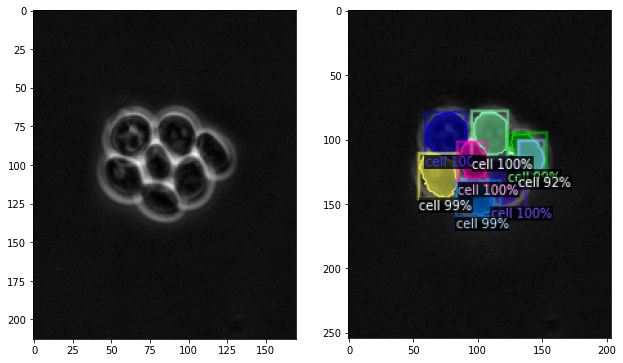

In [50]:
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TEST[0]), scale=1.2)
out_1 = v.draw_instance_predictions(outputs[1]["instances"].to("cpu"))
show_image([im,out_1.get_image()[:, :, ::-1]])
